### Bài thực hành 2: Phân tích Lãi/Lỗ Quyền chọn và "Trading Edge"

**Mục tiêu**

*   Tính toán và trực quan hóa Lãi/Lỗ (P&L) tiềm năng của một vị thế quyền chọn tại ngày đáo hạn dưới các kịch bản giá tài sản khác nhau.
*   Hiểu và mô phỏng khái niệm "Trading Edge" – lợi thế giao dịch có thể có khi giá lý thuyết của quyền chọn (tính bằng mô hình Black-Scholes) khác biệt với giá giao dịch trên thị trường.
*   Sử dụng các module `core.option_analyzer`, `core.black_scholes`, và `core.gbm_simulator` đã xây dựng.

In [6]:
#import và thiết lập môi trường
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if '..' not in sys.path:
    sys.path.append('..')

from core.black_scholes import european_call_price, european_put_price
from core.option_analyzer import (
    calculate_option_pnl_at_expiry,
    simulate_option_pnl_distribution,
    analyze_trading_edge
)
from core.gbm_simulator import simulate_gbm_paths

sns.set_theme(style="whitegrid", palette="muted")

## I. Tính toán và Mô phỏng Phân phối Lãi/Lỗ (P&L) Quyền Chọn

### 1. Tính P&L tại ngày đáo hạn cho một kịch bản giá

Hàm `calculate_option_pnl_at_expiry` từ `core.option_analyzer` sẽ được sử dụng.
Công thức P&L phụ thuộc vào loại quyền chọn (Call/Put) và vị thế (Long/Short).

*   **Long Call P&L:** $\max(0, S_T - K) - \text{Premium Trả}$
*   **Short Call P&L:** $\text{Premium Nhận} - \max(0, S_T - K)$
*   **Long Put P&L:** $\max(0, K - S_T) - \text{Premium Trả}$
*   **Short Put P&L:** $\text{Premium Nhận} - \max(0, K - S_T)$

Trong đó $S_T$ là giá tài sản tại ngày đáo hạn.

In [7]:
# Ví dụ tính P&L cho một kịch bản cụ thể
asset_price_at_expiry_st = 115.0
option_strike_price_k = 100.0
option_premium_transacted = 5.0 # Giả sử phí quyền chọn đã giao dịch
option_type_example = "call"
position_type_example = "long" # Mua Call

pnl_single_scenario = calculate_option_pnl_at_expiry(
    S_T=asset_price_at_expiry_st,
    K=option_strike_price_k,
    premium_transacted=option_premium_transacted,
    option_type=option_type_example,
    position_type=position_type_example
)

print("Ví dụ tính P&L cho vị thế Long Call:")
print("Giá tài sản tại đáo hạn (S_T): ", asset_price_at_expiry_st)
print("Giá thực hiện (K): ", option_strike_price_k)
print("Premium đã trả: ", option_premium_transacted)
print("P&L tính được: ", round(pnl_single_scenario, 2))
# Payoff = max(0, 115-100) = 15. P&L = 15 - 5 = 10.

Ví dụ tính P&L cho vị thế Long Call:
Giá tài sản tại đáo hạn (S_T):  115.0
Giá thực hiện (K):  100.0
Premium đã trả:  5.0
P&L tính được:  10.0


### 2. Mô phỏng Phân phối P&L

Để có cái nhìn tổng thể hơn về rủi ro và lợi nhuận tiềm năng, chúng ta sẽ mô phỏng nhiều kịch bản giá tài sản tại ngày đáo hạn ($S_T$) bằng GBM, sau đó tính P&L cho từng kịch bản. Điều này cho chúng ta một phân phối các kết quả P&L có thể xảy ra.

Hàm `simulate_option_pnl_distribution` từ `core.option_analyzer` sẽ thực hiện việc này. Nó sẽ:
1. Tính toán `premium` giả định dựa trên mô hình Black-Scholes (với `sigma_for_premium_calc`).
2. Mô phỏng nhiều đường giá $S_T$ bằng GBM (với `mu_for_gbm_sim` và `sigma_for_gbm_sim`).
3. Tính P&L cho mỗi $S_T$ dựa trên `premium` đã tính và loại vị thế.

--- Kết quả Mô phỏng Phân phối P&L cho vị thế:  LONG CALL  ---
Premium giả định đã giao dịch (tính với sigma= 0.3 ): $ 6.2163
Số kịch bản mô phỏng:  10000
P&L trung bình mô phỏng: $ 1.3448
Độ lệch chuẩn P&L mô phỏng: $ 11.7966
Xác suất có lãi (P&L > 0) mô phỏng:  36.2 %


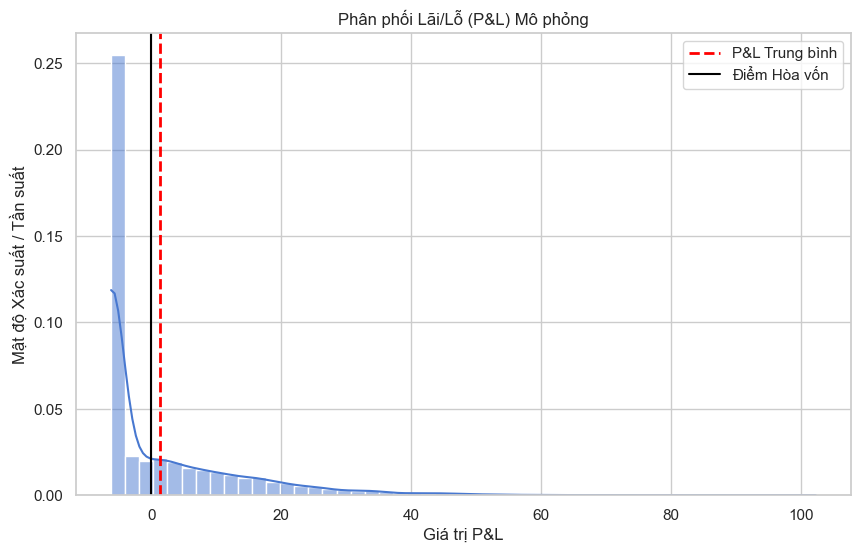

In [8]:
# Tham số cho mô phỏng P&L
pnl_sim_S0 = 100.0
pnl_sim_K = 100.0
pnl_sim_T_years = 0.25 # 3 tháng
pnl_sim_r = 0.02
pnl_sim_sigma_for_premium = 0.30 # Sigma dùng để tính premium giao dịch
pnl_sim_sigma_for_gbm = 0.35     # Sigma thực tế của thị trường (có thể khác)
pnl_sim_mu_for_gbm = 0.05        # Drift thực tế của thị trường (có thể khác r)
pnl_sim_option_type = "call"
pnl_sim_position_type = "long"   # Mua Call
pnl_sim_num_paths = 10000        # Số lượng kịch bản mô phỏng
pnl_sim_seed = 42

# Chạy mô phỏng P&L
simulated_pnl_values, assumed_premium = simulate_option_pnl_distribution(
    S0=pnl_sim_S0,
    K=pnl_sim_K,
    T=pnl_sim_T_years,
    r=pnl_sim_r,
    sigma_for_premium_calc=pnl_sim_sigma_for_premium,
    sigma_for_gbm_sim=pnl_sim_sigma_for_gbm,
    mu_for_gbm_sim=pnl_sim_mu_for_gbm,
    option_type=pnl_sim_option_type,
    position_type=pnl_sim_position_type,
    num_sim_paths=pnl_sim_num_paths,
    random_seed=pnl_sim_seed
)

# In một vài thống kê cơ bản
print("--- Kết quả Mô phỏng Phân phối P&L cho vị thế: ", pnl_sim_position_type.upper(), pnl_sim_option_type.upper(), " ---")
print("Premium giả định đã giao dịch (tính với sigma=", pnl_sim_sigma_for_premium, "): $", round(assumed_premium, 4))
print("Số kịch bản mô phỏng: ", pnl_sim_num_paths)
print("P&L trung bình mô phỏng: $", round(np.mean(simulated_pnl_values), 4))
print("Độ lệch chuẩn P&L mô phỏng: $", round(np.std(simulated_pnl_values), 4))
print("Xác suất có lãi (P&L > 0) mô phỏng: ", round(np.mean(simulated_pnl_values > 0) * 100, 2), "%")

# Trực quan hóa phân phối P&L
plt.figure(figsize=(10, 6))
sns.histplot(simulated_pnl_values, bins=50, kde=True, stat="density")
plt.axvline(np.mean(simulated_pnl_values), color='red', linestyle='dashed', linewidth=2, label="P&L Trung bình")
plt.axvline(0, color='black', linestyle='solid', linewidth=1.5, label="Điểm Hòa vốn")
plt.title("Phân phối Lãi/Lỗ (P&L) Mô phỏng")
plt.xlabel("Giá trị P&L")
plt.ylabel("Mật độ Xác suất / Tần suất")
plt.legend()
plt.show()

## II. Phân tích "Trading Edge"

"Trading Edge" (lợi thế giao dịch) xuất hiện khi giá trị lý thuyết của một quyền chọn (theo mô hình của bạn) khác biệt với giá mà bạn có thể thực sự giao dịch trên thị trường.

Hàm `analyze_trading_edge` từ `core.option_analyzer` sẽ giúp chúng ta:
1.  Tính giá trị lý thuyết Black-Scholes (`theoretical_bs_price`) dựa trên `sigma_model_theoretical` của bạn.
2.  Tính "edge" bằng cách so sánh `theoretical_bs_price` với `market_price_transacted`.
    *   Nếu mua (trade\_action="buy"): `edge = theoretical_bs_price - market_price_transacted`. Edge > 0 là tốt.
    *   Nếu bán (trade\_action="sell"): `edge = market_price_transacted - theoretical_bs_price`. Edge > 0 là tốt.
3.  Mô phỏng phân phối P&L nếu giao dịch được thực hiện ở `market_price_transacted` nhiều lần, với giá tài sản tuân theo GBM (với `mu_gbm_for_simulation` và `sigma_gbm_for_simulation`).

--- Kết quả Phân tích Trading Edge (Mua Call 'Rẻ') ---
Giá BS lý thuyết (tính với sigma= 0.2 ): $ 10.4506
Giá giao dịch trên thị trường: $ 10.0
Edge xác định trên mỗi cổ phiếu: $ 0.4506
P&L trung bình mô phỏng / giao dịch: $ 1.2649
Độ lệch chuẩn P&L mô phỏng: $ 15.6978
Xác suất có lãi mô phỏng:  38.39 %


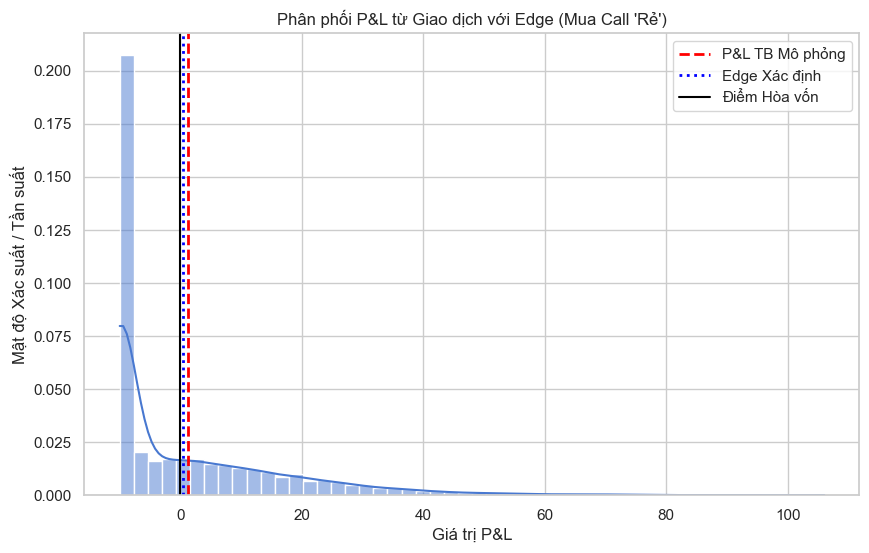

In [9]:
# Tham số cho phân tích trading edge
edge_sim_S0 = 100.0
edge_sim_K = 100.0
edge_sim_T_years = 1.0
edge_sim_r = 0.05
edge_sim_sigma_model = 0.20 # Sigma bạn dùng cho mô hình BS của mình

# Kịch bản 1: Mua Call khi thị trường định giá "rẻ" hơn lý thuyết của bạn
# Giá Call lý thuyết (100,100,1,0.05,0.20) ~ 10.45
edge_sim_market_price_buy_call = 10.00 # Bạn có thể mua với giá 10.00
edge_sim_trade_action_buy = "buy"

# Giả định cho sự vận động thực tế của thị trường khi mô phỏng P&L
edge_sim_mu_gbm = edge_sim_r            # Giả sử drift bằng lãi suất r (risk-neutral)
edge_sim_sigma_gbm = edge_sim_sigma_model # Giả sử vol thực tế khớp với vol mô hình của bạn

edge_sim_num_paths = 10000
edge_sim_seed = 77

# Chạy phân tích trading edge
edge_analysis_results_buy_call = analyze_trading_edge(
    S_initial=edge_sim_S0,
    K=edge_sim_K,
    T=edge_sim_T_years,
    r=edge_sim_r,
    sigma_model_theoretical=edge_sim_sigma_model,
    market_price_transacted=edge_sim_market_price_buy_call,
    option_type="call",
    trade_action=edge_sim_trade_action_buy,
    mu_gbm_simulation=edge_sim_mu_gbm,
    sigma_gbm_simulation=edge_sim_sigma_gbm,
    num_sim_paths=edge_sim_num_paths,
    random_seed=edge_sim_seed
)

# In kết quả phân tích edge
print("--- Kết quả Phân tích Trading Edge (Mua Call 'Rẻ') ---")
print("Giá BS lý thuyết (tính với sigma=", edge_sim_sigma_model, "): $", round(edge_analysis_results_buy_call["theoretical_bs_price"], 4))
print("Giá giao dịch trên thị trường: $", edge_analysis_results_buy_call["market_transaction_price"])
print("Edge xác định trên mỗi cổ phiếu: $", round(edge_analysis_results_buy_call["identified_edge_per_share"], 4))
print("P&L trung bình mô phỏng / giao dịch: $", round(edge_analysis_results_buy_call["simulated_average_pnl"], 4))
print("Độ lệch chuẩn P&L mô phỏng: $", round(edge_analysis_results_buy_call["simulated_std_dev_pnl"], 4))
print("Xác suất có lãi mô phỏng: ", round(edge_analysis_results_buy_call["simulated_prob_of_profit"] * 100, 2), "%")

# Trực quan hóa phân phối P&L từ các giao dịch có edge
plt.figure(figsize=(10, 6))
sns.histplot(edge_analysis_results_buy_call["pnl_distribution_simulated_array"], bins=50, kde=True, stat="density")
plt.axvline(edge_analysis_results_buy_call["simulated_average_pnl"], color='red', linestyle='dashed', linewidth=2, label="P&L TB Mô phỏng")
plt.axvline(edge_analysis_results_buy_call["identified_edge_per_share"], color='blue', linestyle='dotted', linewidth=2, label="Edge Xác định")
plt.axvline(0, color='black', linestyle='solid', linewidth=1.5, label="Điểm Hòa vốn")
plt.title("Phân phối P&L từ Giao dịch với Edge (Mua Call 'Rẻ')")
plt.xlabel("Giá trị P&L")
plt.ylabel("Mật độ Xác suất / Tần suất")
plt.legend()
plt.show()

### Thử một kịch bản Trading Edge khác: Bán Put khi thị trường định giá "cao" hơn lý thuyết.

Giả sử mô hình của bạn tính giá Put là $X$. Nếu bạn có thể bán Put đó với giá $Y > X$, bạn có edge.


--- Kết quả Phân tích Trading Edge (Bán Put 'Đắt') ---
Giá BS lý thuyết (tính với sigma= 0.25 ): $ 4.0825
Giá giao dịch trên thị trường: $ 4.0
Edge xác định trên mỗi cổ phiếu: $ -0.0825
P&L trung bình mô phỏng / giao dịch: $ -0.234
Độ lệch chuẩn P&L mô phỏng: $ 7.1894
Xác suất có lãi mô phỏng:  69.69 %


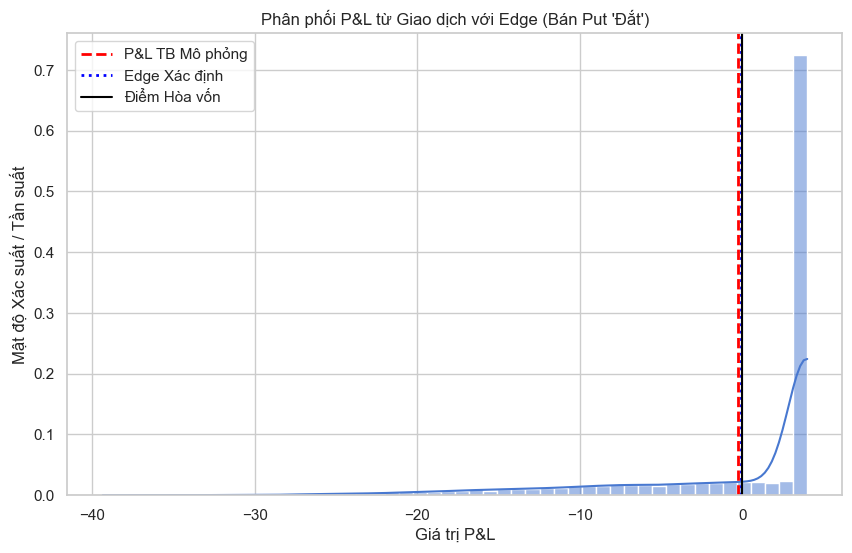

In [10]:
# Kịch bản 2: Bán Put khi thị trường trả giá "cao" hơn lý thuyết của bạn
# Giá Put lý thuyết (S=100, K=95, T=0.5, r=0.03, sigma_model=0.25) là ~ $3.49
edge_sim_S0_put = 100.0
edge_sim_K_put = 95.0
edge_sim_T_years_put = 0.5
edge_sim_r_put = 0.03
edge_sim_sigma_model_put = 0.25

edge_sim_market_price_sell_put = 4.00 # Bạn bán được Put với giá 4.00
edge_sim_trade_action_sell = "sell"

# Giả định thị trường vẫn như cũ
edge_sim_mu_gbm_put = edge_sim_r_put
edge_sim_sigma_gbm_put = edge_sim_sigma_model_put

edge_analysis_results_sell_put = analyze_trading_edge(
    S_initial=edge_sim_S0_put,
    K=edge_sim_K_put,
    T=edge_sim_T_years_put,
    r=edge_sim_r_put,
    sigma_model_theoretical=edge_sim_sigma_model_put,
    market_price_transacted=edge_sim_market_price_sell_put,
    option_type="put",
    trade_action=edge_sim_trade_action_sell,
    mu_gbm_simulation=edge_sim_mu_gbm_put,
    sigma_gbm_simulation=edge_sim_sigma_gbm_put,
    num_sim_paths=edge_sim_num_paths, # Dùng lại số path như trên
    random_seed=edge_sim_seed + 1 # Seed khác đi một chút
)

# In kết quả phân tích edge
print("\n--- Kết quả Phân tích Trading Edge (Bán Put 'Đắt') ---")
print("Giá BS lý thuyết (tính với sigma=", edge_sim_sigma_model_put, "): $", round(edge_analysis_results_sell_put["theoretical_bs_price"], 4))
print("Giá giao dịch trên thị trường: $", edge_analysis_results_sell_put["market_transaction_price"])
print("Edge xác định trên mỗi cổ phiếu: $", round(edge_analysis_results_sell_put["identified_edge_per_share"], 4))
print("P&L trung bình mô phỏng / giao dịch: $", round(edge_analysis_results_sell_put["simulated_average_pnl"], 4))
print("Độ lệch chuẩn P&L mô phỏng: $", round(edge_analysis_results_sell_put["simulated_std_dev_pnl"], 4))
print("Xác suất có lãi mô phỏng: ", round(edge_analysis_results_sell_put["simulated_prob_of_profit"] * 100, 2), "%")

# Trực quan hóa
plt.figure(figsize=(10, 6))
sns.histplot(edge_analysis_results_sell_put["pnl_distribution_simulated_array"], bins=50, kde=True, stat="density")
plt.axvline(edge_analysis_results_sell_put["simulated_average_pnl"], color='red', linestyle='dashed', linewidth=2, label="P&L TB Mô phỏng")
plt.axvline(edge_analysis_results_sell_put["identified_edge_per_share"], color='blue', linestyle='dotted', linewidth=2, label="Edge Xác định")
plt.axvline(0, color='black', linestyle='solid', linewidth=1.5, label="Điểm Hòa vốn")
plt.title("Phân phối P&L từ Giao dịch với Edge (Bán Put 'Đắt')")
plt.xlabel("Giá trị P&L")
plt.ylabel("Mật độ Xác suất / Tần suất")
plt.legend()
plt.show()